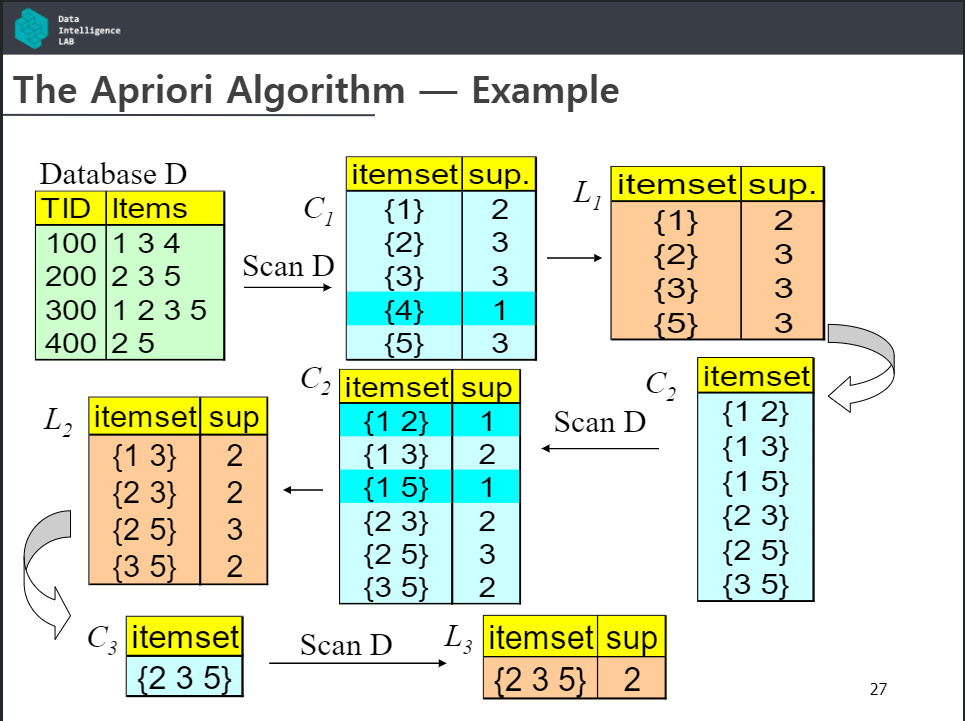

In [1]:
def my_apriori(data, min_support=0.5):
    """ 메인 Apripri알고리즘
    Ck: Lk-1로부터 생성한 size k의 후보 itemset
    Lk: Ck로부터 minimum support를 고려한 size k의 frequent itemset
    
    L1을 생성하고, 
    Ck와 Lk를 반복하여 생성하며 더이상 candidate item이 없거나 
    frequent item이 없을 때 까지 반복
    
    Parameters
    ----------
    data: pd.Dataframe
        row: transaction, column: item으로 onehot encoding 된
        데이터프레임
        
    min_support: float
        association rule에서 frequent item을 만족하기 위한
        최소 support
    
    Return
    ----------
    pd.Dataframe
    모든 길이의 frequent itemset과 그 support를 반환
    
        support   itemsets
    0   0.3       (coffee)
    1   0.2       (coffee, bread)
    2   0.4       (coffee, break, cake)
    ...
    
    """

    def _support(_x, _n_rows):
        """Support 계산"""
        out = (np.sum(_x, axis=0) / _n_rows) 
        return out

    if min_support <= 0.:
        raise ValueError('`min_support` must be a positive number '
                         'within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    X = data.values
    support = _support(X, X.shape[0]) # 모든 item의 support를 구함
    
    """ Apriori process 
    각 단계별로 itemset의 길이를 key로 하고, 
    1. minimum support를 만족하는 itemset을 value로 가지는 자료구조와
    2. 해당 itemset의 support를 value로 가지는 자료구조 생성
    
    while:
        generate_combination 함수로부터 새로운 Ck 생성
        새로운 Ck가 없으면 break
        
        Ck < Ck 중 원본 DB에 있는 itemset들만 추출
        Ck의 support를 구하고 min_support 검사
        min_support를 만족하는 itemset이 없으면 break
        
        min_support를 만족하는 Ck(Lk)를 처음 만든 자료구조에 추가
        
    출력 포멧에 맞추어 자료구조를 변형하여 출력
    """

    #key: itemset 길이
    #value: 길이에 맞는 itemset들 중 minsupport를 만족하는 itemset들의 support를 저장
    support_dict = {1: support[support >= min_support]}
    
    #key: itemset 길이
    #value: 길이에 맞는 itemset들 중 minsupport를 만족하는 itemset을 저장
    ary_col_idx = np.arange(X.shape[1])
    itemset_dict = {1: ary_col_idx[support >= min_support].reshape(-1, 1)} 

    max_itemset = 1
    rows_count = float(X.shape[0])

    all_ones = np.ones((int(rows_count), 1))
    print(X.shape)
    while max_itemset and max_itemset <  float('inf'):
        next_max_itemset = max_itemset + 1

        ## combi << C(K+1) (selfjoin process)
        # generator로부터 모든 조합을 1개 row로 추출하고, 이후 reshape
        combi = generate_combination(itemset_dict[max_itemset]) # e.g. 1\n2, 1\n3, 1\n4 ... 99\n100
        combi = np.fromiter(combi, dtype=int) # dtype + array 변환
        combi = combi.reshape(-1, next_max_itemset) # e.g. C(k+1) : np.array([1,2], ..., [99,100])

        # 새로운 조합이 더이상 나오지 않으면 stop
        if combi.size == 0:
            break
        
        ## C(k+1) -> L(k+1)
        
        _bools = np.all(X[:, combi], axis=2)   # 각 transaction마다 combi의 itemset을 모두 scan, True/False, shape : (transaction, len(combi)) - fancy indexing
        support = _support(_bools, rows_count) # 새로운 step의 support, shape : (len(combi),)

        _mask = (support > min_support).reshape(-1) # min_sup를 만족하는 L(k+1) mask

        if any(_mask): # L(k+1) 생성
            itemset_dict[next_max_itemset] = np.array(combi[_mask])
            support_dict[next_max_itemset] = np.array(support[_mask])
            max_itemset = next_max_itemset

        else:
            break
            
    """
    support_dic와 itemset_dict를 활용하여 
    원하는 output 형태로 변환
    """
    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]]) # frozenset : 구성 요소를 변경할 수 없는 set

        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ['support', 'itemsets']

    mapping = {idx: item for idx, item in enumerate(data.columns)}
    res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([mapping[i] for i in x])) # apply() : ()안의 함수 적용, lambda : 일회용 함수

    res_df = res_df.reset_index(drop=True)

    return res_df

In [2]:
def generate_combination(old_combinations):
    """Self join 프로세스 (Lk에서 Ck+1을 제작)
    이전 step에서의 itemset들을 self join하여
    다음 step에서 활용할 itemset을 제작하고 return.
    이때 새로운 itemset의 legnth는 이전 itemset의 length+1
    
    Lk의 itemset l1, l2가 있을 때, 
    l1[0]~l1[k-2] == l2[0]~l2[k-2]이고
    l1[k-1] > l2[k-1] 일때만 l1과 l2의 selfjoin이 가능.
    Self join의 결과는 l1 + l2[k-1]
    
    Parameters
    ----------
    old_combinations: np.array
        이전 step에서 minimum support를 만족하는 itemset의 집합(Lk).
        Matrix로 표현되어 row는 하나의 itemset을 표현.
        Matrix의 column의 갯수는 이전 step에서 itemset의 갯수를 의미.
    
    Returns
    ----------
    이전 step의 itemset들을 self join한
    댜음 step의 itemset의 tule
    """
    
    """
    self join의 효율적인 process
    unique_item_in_prev < old_combinations에서 unique한 itemset을 구함
    old_combinations의 각 combination에 대해
        new_combination < combination + (unique_item 중 combination[k-1]보다 큰것)
    가능한 모든 new_combination 들을 return
    
    """
    # 이전 step에서 unique한 item들을 추출
    unique_item_in_previous_step = np.unique(old_combinations.flatten())
    
    for old_combination in old_combinations:
        #max값을 뽑아 해당 값보다 큰 unique item들과 combination을 조합
        max_combination = old_combination[-1] # []안 숫자 e.g. 1
        mask = unique_item_in_previous_step > max_combination # e.g. 1 : False, 2 ~ : True
        valid_items = unique_item_in_previous_step[mask] # e.g. 2 ~
        old_tuple = tuple(old_combination) # e.g. 1
        for item in valid_items: # e.g. 1\n2, 1\n3, 1\n4 ... 99\n100
            yield from old_tuple 
            yield item

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

basicpath = '/content/drive/MyDrive/'

Mounted at /content/drive


#### Data : https://www.kaggle.com/datasets/mittalvasu95/the-bread-basket

In [5]:
path = basicpath + 'Datascience_code'
file = 'BreadBasket_DMS.csv'
data = pd.read_csv(os.path.join(path, file), index_col = None)

In [6]:
data.head(10)

,Date,Time,Transaction,Item
0,2016.10.30,9:58:11,1,Bread
1,2016.10.30,10:05:34,2,Scandinavian
2,2016.10.30,10:05:34,2,Scandinavian
3,2016.10.30,10:07:57,3,Hot chocolate
4,2016.10.30,10:07:57,3,Jam
5,2016.10.30,10:07:57,3,Cookies
6,2016.10.30,10:08:41,4,Muffin
7,2016.10.30,10:13:03,5,Coffee
8,2016.10.30,10:13:03,5,Pastry
9,2016.10.30,10:13:03,5,Bread


# Data cleaning

### 편의를 위해 소문자로 변환

In [7]:
data['Item'] = data['Item'].str.lower()
data.head(3)

,Date,Time,Transaction,Item
0,2016.10.30,9:58:11,1,bread
1,2016.10.30,10:05:34,2,scandinavian
2,2016.10.30,10:05:34,2,scandinavian


### Data의 none value 제거

In [8]:
data.isnull().sum()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

In [9]:
data.iloc[25:30]

,Date,Time,Transaction,Item
25,2016.10.30,10:27:21,11,bread
26,2016.10.30,10:27:21,11,none
27,2016.10.30,10:30:14,12,jam
28,2016.10.30,10:30:14,12,coffee
29,2016.10.30,10:30:14,12,tartine


In [10]:
data.iloc[26]

Date           2016.10.30
Time             10:27:21
Transaction            11
Item                 none
Name: 26, dtype: object

In [11]:
data['Item'].unique() # numeric data > 999 / -1(정수 범위일 때)

array(['bread', 'scandinavian', 'hot chocolate', 'jam', 'cookies',
       'muffin', 'coffee', 'pastry', 'medialuna', 'tea', 'none',
       'tartine', 'basket', 'mineral water', 'farm house', 'fudge',
       'juice', "ella's kitchen pouches", 'victorian sponge', 'frittata',
       'hearty & seasonal', 'soup', 'pick and mix bowls', 'smoothies',
       'cake', 'mighty protein', 'chicken sand', 'coke',
       'my-5 fruit shoot', 'focaccia', 'sandwich', 'alfajores', 'eggs',
       'brownie', 'dulce de leche', 'honey', 'the bart', 'granola',
       'fairy doors', 'empanadas', 'keeping it local', 'art tray',
       'bowl nic pitt', 'bread pudding', 'adjustment', 'truffles',
       'chimichurri oil', 'bacon', 'spread', 'kids biscuit', 'siblings',
       'caramel bites', 'jammie dodgers', 'tiffin', 'olum & polenta',
       'polenta', 'the nomad', 'hack the stack', 'bakewell',
       'lemon and coconut', 'toast', 'scone', 'crepes', 'vegan mincepie',
       'bare popcorn', 'muesli', 'crisps', 'pi

In [12]:
(data['Item'] == 'none').value_counts()

False    20507
True       786
Name: Item, dtype: int64

In [13]:
len(data)

21293

In [14]:
data = data.drop(data[data['Item'] == 'none'].index) 
# data.drop(data[data['Item'] == 'none'].index, inplace=True)
# data = data[data['Item'] != 'none']

In [15]:
len(data)

20507

In [16]:
len(data['Item'].unique())

94

### Data 간단 분석_item당 등장횟수

In [17]:
top10_items = data['Item'].value_counts().head(10)
top10_items

coffee           5471
bread            3325
tea              1435
cake             1025
pastry            856
sandwich          771
medialuna         616
hot chocolate     590
cookies           540
brownie           379
Name: Item, dtype: int64

# 모델 활용

### Data형태 변환 : Vertical format

In [18]:
hot_encoded_data = data.groupby(['Transaction','Item'])['Item'].count().unstack().fillna(0)
hot_encoded_data.head(9)

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#하나의 transaction에 2개 이상의 동일한 item이 들어간 경우 1개로 취급. 
#item 간의 관계가 중요. 동일한 item끼리는 중요하지 않음
def encode_units(x): 
    if x <= 0:
        return 0
    if x >= 1:
        return 1

hot_encoded_data = hot_encoded_data.applymap(encode_units)
hot_encoded_data

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def _support(_x, _n_rows):
    """Support 계산"""
    out = (np.sum(_x, axis=0) / _n_rows) 
    return out

In [21]:
_support(hot_encoded_data,hot_encoded_data.shape[0])

Item
adjustment                  0.000106
afternoon with the baker    0.004543
alfajores                   0.036344
argentina night             0.000740
art tray                    0.004015
                              ...   
tshirt                      0.002219
valentine's card            0.001373
vegan feast                 0.001690
vegan mincepie              0.005494
victorian sponge            0.000740
Length: 94, dtype: float64

In [22]:
frequent_items = my_apriori(hot_encoded_data, 0.01)
frequent_items

(9465, 94)


,support,itemsets
0,0.036344,(alfajores)
1,0.016059,(baguette)
2,0.327205,(bread)
3,0.040042,(brownie)
4,0.103856,(cake)
...,...,...
56,0.023666,"(coffee, toast)"
57,0.014369,"(tea, sandwich)"
58,0.010037,"(coffee, cake, bread)"
59,0.011199,"(pastry, coffee, bread)"
